# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [113]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/hanaebm/mlfs-book


In [114]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [115]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 14, 14, 55, 59, 480367)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [116]:
project = hopsworks.login()
fs = project.get_feature_store() 
import argparse, json

parser = argparse.ArgumentParser()
parser.add_argument("--id", type=int, default=1)
args, _ = parser.parse_known_args()
id=args.id
#import os
#id = int(os.environ.get("id", 1))

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret(f"SENSOR_{id}_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-14 14:55:59,501 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-14 14:55:59,513 INFO: Initializing external client
2025-11-14 14:55:59,515 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-14 14:56:01,140 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271987


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [117]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name=f"air_quality_xgboost_model_{id}",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-14 14:56:06,058 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/491674 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112787 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26057 elapsed<00:00 remaining<?

In [118]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + f"/model_{id}.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.068322E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [119]:
weather_fg = fs.get_feature_group(
    name=f'weather_{id}',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name=f'air_quality_{id}',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()

batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-17 00:00:00+00:00,4.45,0.0,14.707222,338.458954,helsingborg
1,2025-11-15 00:00:00+00:00,3.90,0.0,5.154416,77.905258,helsingborg
2,2025-11-18 00:00:00+00:00,6.00,0.0,20.124611,227.174759,helsingborg
3,2025-11-16 00:00:00+00:00,5.35,0.0,12.434340,247.890503,helsingborg
4,2025-11-19 00:00:00+00:00,3.20,0.2,5.241679,105.945465,helsingborg
5,2025-11-20 00:00:00+00:00,2.65,0.1,11.681987,56.309914,helsingborg


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [140]:
import numpy as np
import pandas as pd
import datetime

# Initialisation des colonnes
for lag in range(1, 4):
    batch_data[f"pm25_lag_{lag}"] = np.nan
batch_data["predicted_pm25"] = np.nan

# Trier les données par date
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

# Récupérer "today" depuis batch_data
today = batch_data.loc[0, "date"]
if not isinstance(today, pd.Timestamp):
    today = pd.Timestamp(today, tz='UTC')

# Lire toutes les données du Feature Group dans un DataFrame Pandas
air_quality_df = air_quality_fg.read()  # <-- maintenant on a un DataFrame Pandas

# S'assurer que la colonne date est bien en datetime
air_quality_df['date'] = pd.to_datetime(air_quality_df['date'], utc=True)

# Remplissage de la première ligne
for lag in [1, 2, 3]:
    date_to_fetch = today - pd.Timedelta(days=lag-1)
    feature_name = f"pm25_lag_{lag}"

    # Filtrer par date uniquement
    filtered_df = air_quality_df[air_quality_df['date'].dt.date == date_to_fetch.date()]

    if not filtered_df.empty:
        if feature_name in filtered_df.columns:
            batch_data.loc[0, feature_name] = filtered_df.iloc[0][feature_name]
        else:
            batch_data.loc[0, feature_name] = filtered_df.iloc[0]["pm25"]  # ajuster si nécessaire

# Colonnes pour le modèle
cols = ["pm25_lag_1","pm25_lag_2","pm25_lag_3",
        "temperature_2m_mean","precipitation_sum",
        "wind_speed_10m_max","wind_direction_10m_dominant"]

# Première prédiction
batch_data.loc[0, "predicted_pm25"] = retrieved_xgboost_model.predict(
    batch_data.loc[[0], cols]
)[0]

# Remplissage des lignes suivantes
for i in range(1, len(batch_data)):
    batch_data.loc[i, "pm25_lag_1"] = batch_data.loc[i-1, "predicted_pm25"]
    batch_data.loc[i, "pm25_lag_2"] = batch_data.loc[i-1, "pm25_lag_1"]
    batch_data.loc[i, "pm25_lag_3"] = batch_data.loc[i-1, "pm25_lag_2"]

    batch_data.loc[i, "predicted_pm25"] = retrieved_xgboost_model.predict(
        batch_data.loc[[i], cols]
    )[0]

batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2025-11-15 00:00:00+00:00,3.90,0.0,5.154416,77.905258,helsingborg,NaN,10.000000,NaN,119.346176
1,2025-11-16 00:00:00+00:00,5.35,0.0,12.434340,247.890503,helsingborg,119.346176,NaN,10.000000,98.897125
2,2025-11-17 00:00:00+00:00,4.45,0.0,14.707222,338.458954,helsingborg,98.897125,119.346176,NaN,49.972107
3,2025-11-18 00:00:00+00:00,6.00,0.0,20.124611,227.174759,helsingborg,49.972107,98.897125,119.346176,45.337708
4,2025-11-19 00:00:00+00:00,3.20,0.2,5.241679,105.945465,helsingborg,45.337708,49.972107,98.897125,51.387669
5,2025-11-20 00:00:00+00:00,2.65,0.1,11.681987,56.309914,helsingborg,51.387669,45.337708,49.972107,39.649593


In [73]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1                   5 non-null      float64                
 7   pm25_lag_2                   5 non-null      float64                
 8   pm25_lag_3                   4 non-null      float64                
 9   predicted_pm25               6 non-null      float64                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [74]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-15 00:00:00+00:00,3.90,0.0,5.154416,77.905258,helsingborg,77.292435,NaN,10.000000,35.070255,drottninggatan,sweden,2
3,2025-11-16 00:00:00+00:00,5.35,0.0,12.434340,247.890503,helsingborg,40.754601,35.070255,77.292435,61.590710,drottninggatan,sweden,4
0,2025-11-17 00:00:00+00:00,4.45,0.0,14.707222,338.458954,helsingborg,NaN,10.000000,NaN,77.292435,drottninggatan,sweden,1
2,2025-11-18 00:00:00+00:00,6.00,0.0,20.124611,227.174759,helsingborg,35.070255,77.292435,NaN,40.754601,drottninggatan,sweden,3
4,2025-11-19 00:00:00+00:00,3.20,0.2,5.241679,105.945465,helsingborg,61.590710,40.754601,35.070255,76.249397,drottninggatan,sweden,5
5,2025-11-20 00:00:00+00:00,2.65,0.1,11.681987,56.309914,helsingborg,76.249397,61.590710,40.754601,42.852684,drottninggatan,sweden,6


In [75]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 5
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1                   5 non-null      float64                
 7   pm25_lag_2                   5 non-null      float64                
 8   pm25_lag_3                   4 non-null      float64                
 9   predicted_pm25               6 non-null      float64                
 10  street     

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

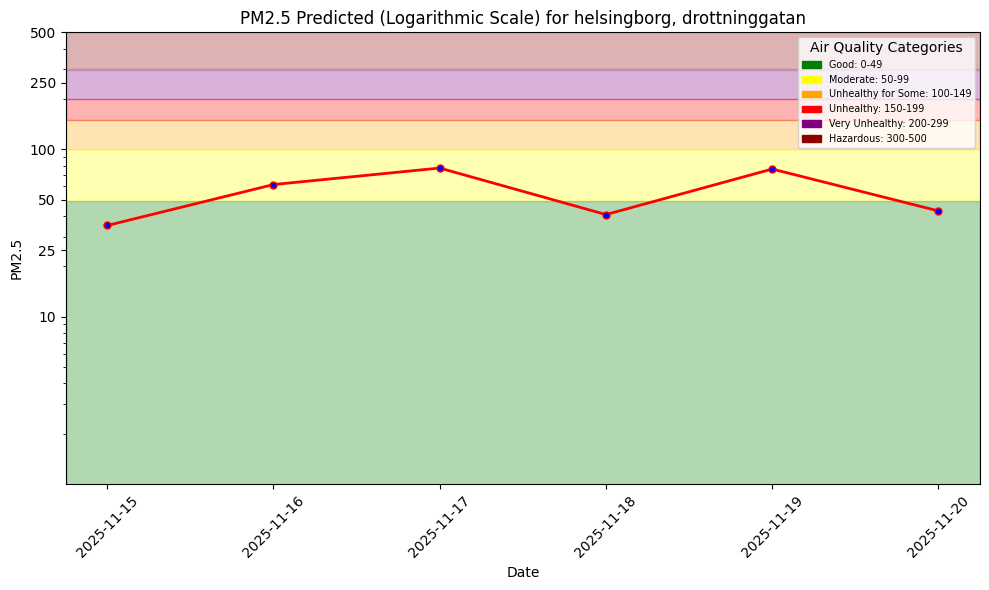

In [76]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{id}.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [77]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions_{id}',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [78]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271987/jobs/named/aq_predictions_1_1_offline_fg_materialization/executions
2025-11-14 14:35:09,822 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-14 14:35:13,103 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 14:36:51,355 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 14:36:51,592 INFO: Waiting for log aggregation to finish.
2025-11-14 14:36:59,771 INFO: Execution finished successfully.


(Job('aq_predictions_1_1_offline_fg_materialization', 'SPARK'), None)

In [79]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,4.450000,0.0,14.707222,338.458954,helsingborg,NaN,10.0,NaN,77.292435,drottninggatan,sweden,1
1,2025-11-12 00:00:00+00:00,9.950000,0.3,27.419146,176.236038,helsingborg,30.0,30.0,30.0,29.062994,drottninggatan,sweden,1
2,2025-10-27 00:00:00+00:00,7.803751,8.6,22.017466,251.533035,helsingborg,13.0,17.0,11.0,16.843164,drottninggatan,sweden,1
3,2025-10-28 00:00:00+00:00,8.253750,2.1,24.233240,258.429871,helsingborg,10.0,13.0,17.0,13.696150,drottninggatan,sweden,1
4,2025-11-04 00:00:00+00:00,12.382916,4.1,23.717690,209.422226,helsingborg,32.0,34.0,40.0,28.857182,drottninggatan,sweden,1
5,2025-10-31 00:00:00+00:00,8.799582,0.0,23.513952,181.116562,helsingborg,19.0,27.0,15.0,27.806534,drottninggatan,sweden,1
6,2025-10-26 00:00:00+00:00,8.099584,0.7,24.326651,203.839325,helsingborg,17.0,11.0,32.0,29.954800,drottninggatan,sweden,1
7,2025-10-24 00:00:00+00:00,11.232917,0.7,32.730808,186.412903,helsingborg,32.0,34.0,48.0,32.723736,drottninggatan,sweden,1
8,2025-10-25 00:00:00+00:00,9.618333,6.0,29.962837,190.119339,helsingborg,11.0,32.0,34.0,30.962063,drottninggatan,sweden,1
9,2025-10-29 00:00:00+00:00,9.807918,7.2,25.282791,215.591660,helsingborg,15.0,10.0,13.0,21.631662,drottninggatan,sweden,1


In [80]:
air_quality_fg = fs.get_feature_group(name=f'air_quality_{id}', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2024-08-03 00:00:00+00:00,29.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,25.0,23.0,20.0
1,2020-08-03 00:00:00+00:00,16.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,20.0,25.0,20.0
2,2021-07-19 00:00:00+00:00,21.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,28.0,35.0,52.0
3,2025-08-11 00:00:00+00:00,23.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,28.0,27.0,38.0
4,2023-08-14 00:00:00+00:00,30.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,28.0,30.0,19.0
...,...,...,...,...,...,...,...,...,...
1934,2024-10-24 00:00:00+00:00,50.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,30.0,32.0,46.0
1935,2021-07-14 00:00:00+00:00,65.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,40.0,29.0,16.0
1936,2022-09-29 00:00:00+00:00,7.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,9.0,17.0,14.0
1937,2025-11-12 00:00:00+00:00,30.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,30.0,30.0,30.0


In [81]:
import importlib
importlib.reload(util)

<module 'mlfs.airquality.util' from '/home/hanaebm/mlfs-book/mlfs/airquality/util.py'>

In [82]:
outcome_df = air_quality_df[['date', 'pm25']]
monitoring_df['predicted_pm25']=monitoring_df['predicted_pm25'].astype('float64')

preds_df =  monitoring_df[['date', 'predicted_pm25']]


hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

features_df = air_quality_fg.select(['date','pm25_lag_1','pm25_lag_2','pm25_lag_3','city']).join(
    weather_fg.select_features(), on=['city']
).read()  

for col in ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']:
    if col in features_df.columns:
        features_df[col] = features_df[col].astype('float64')

    
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(features_df, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

2025-11-14 14:37:04,298 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_1` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 


,date,predicted_pm25,pm25
6,2025-10-24 00:00:00+00:00,32.723736,11.0
7,2025-10-25 00:00:00+00:00,30.962063,17.0
5,2025-10-26 00:00:00+00:00,29.954800,13.0
1,2025-10-27 00:00:00+00:00,16.843164,10.0
2,2025-10-28 00:00:00+00:00,13.696150,15.0
8,2025-10-29 00:00:00+00:00,21.631662,27.0
9,2025-10-30 00:00:00+00:00,24.344561,19.0
4,2025-10-31 00:00:00+00:00,27.806534,19.0
3,2025-11-04 00:00:00+00:00,28.857182,24.0
0,2025-11-12 00:00:00+00:00,29.062994,30.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

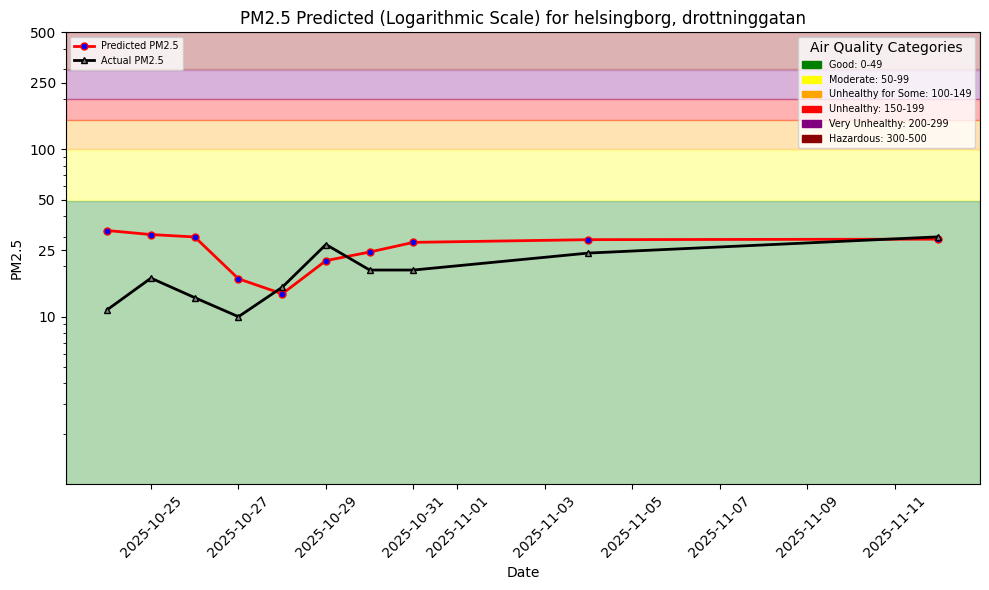

In [83]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{id}.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [84]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/hanaebm/mlfs-book/docs/air-quality/assets/img/pm25_forecast_1.png: 0.000%|          | 0/47114 …

Uploading /home/hanaebm/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_1.png: 0.000%|          | 0/5…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1271987/settings/fb/path/Resources/airquality


---